In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("standard_heartrate.csv")
df = df.iloc[:, 1:] 
df

,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Diet_encoded,Systolic BP,Diastolic BP,Continent_Africa,Continent_Asia,Continent_Australia,Continent_Europe,Continent_North America,Continent_South America,hemisphere_encoded
0,0.625557,Male,-0.641579,-0.147042,0,0,1,0,0,-1.010838,...,-1.225914,0.870044,0.193782,False,False,False,False,False,True,0
1,-1.539322,Male,1.596895,1.118179,1,1,1,1,1,-1.418027,...,1.231804,1.135714,0.534480,False,False,False,False,True,False,1
2,-1.539322,Female,0.793023,-0.147042,1,0,0,0,0,-1.372188,...,0.002945,1.477290,0.943319,False,False,False,True,False,False,1
3,1.425621,Male,1.522691,-0.098380,1,1,1,0,1,-0.032188,...,-1.225914,1.059809,1.011458,False,False,False,False,True,False,1
4,0.578495,Male,0.718820,0.874867,1,1,1,1,0,-0.727941,...,1.231804,-1.672797,0.193782,False,True,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,0.296119,Male,-1.717530,-0.682328,1,1,1,0,1,-0.362578,...,0.002945,-1.558939,-0.623895,False,True,False,False,False,False,1
8759,-1.209884,Female,-1.729898,-0.098380,1,0,0,1,0,1.131536,...,0.002945,0.832092,1.147738,False,False,False,False,True,False,1
8760,-0.315695,Male,-0.122154,1.458815,0,1,1,1,1,-1.187161,...,-1.225914,0.983903,-0.692035,False,False,False,False,False,True,0
8761,-0.833383,Male,-1.012597,-0.730990,1,0,1,0,0,-1.076238,...,1.231804,-0.610117,-1.237152,False,False,False,False,False,True,0


In [3]:
X = df.drop("Heart Attack Risk", axis = 1)
X = pd.get_dummies(X, drop_first=True)
y = df["Heart Attack Risk"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Setting up the pipeline with SMOTE for handling class imbalance and Random Forest Classifier
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Parameters for GridSearchCV
param_grid = {
    'classifier__n_estimators': [300, 400, 500],  # Number of trees in the forest
    'classifier__max_depth': [20, 40],  # Maximum depth of the tree
    'classifier__min_samples_leaf': [4, 5],  # Minimum number of samples required at each leaf node
    'classifier__max_features': [4, 5, 6]
}

# Cross-validation and parameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters found
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

({'classifier__max_depth': 40,
  'classifier__max_features': 5,
  'classifier__min_samples_leaf': 4,
  'classifier__n_estimators': 400},
 0.6022824536376604)

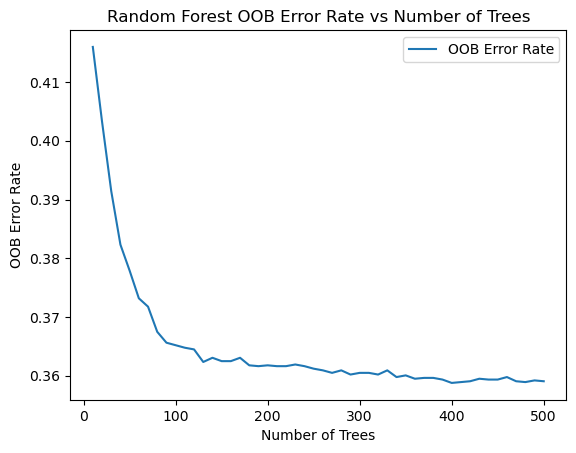

In [5]:
n_estimators_range = range(10, 501, 10)

oob_errors = []

# Iterate over the range and calculate OOB errors
for n_estimators in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=40, min_samples_leaf=4, oob_score=True, n_jobs=-1, random_state=42)
    rf.fit(X_train, y_train)
    # Record the OOB error for each `n_estimators` setting.
    oob_error = 1 - rf.oob_score_
    oob_errors.append(oob_error)

# Generate the plot
plt.plot(n_estimators_range, oob_errors, label='OOB Error Rate')
plt.xlabel('Number of Trees')
plt.ylabel('OOB Error Rate')
plt.title('Random Forest OOB Error Rate vs Number of Trees')
plt.legend()
plt.show()

In [7]:
# Evaluation on the test set using the best model
y_pred = grid_search.best_estimator_.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy on the Test Set: {test_accuracy}")
print("Classification Report:")
print(classification_rep)

Accuracy on the Test Set: 0.5881346263548203
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.82      0.72      1125
           1       0.35      0.17      0.23       628

    accuracy                           0.59      1753
   macro avg       0.49      0.50      0.47      1753
weighted avg       0.54      0.59      0.54      1753



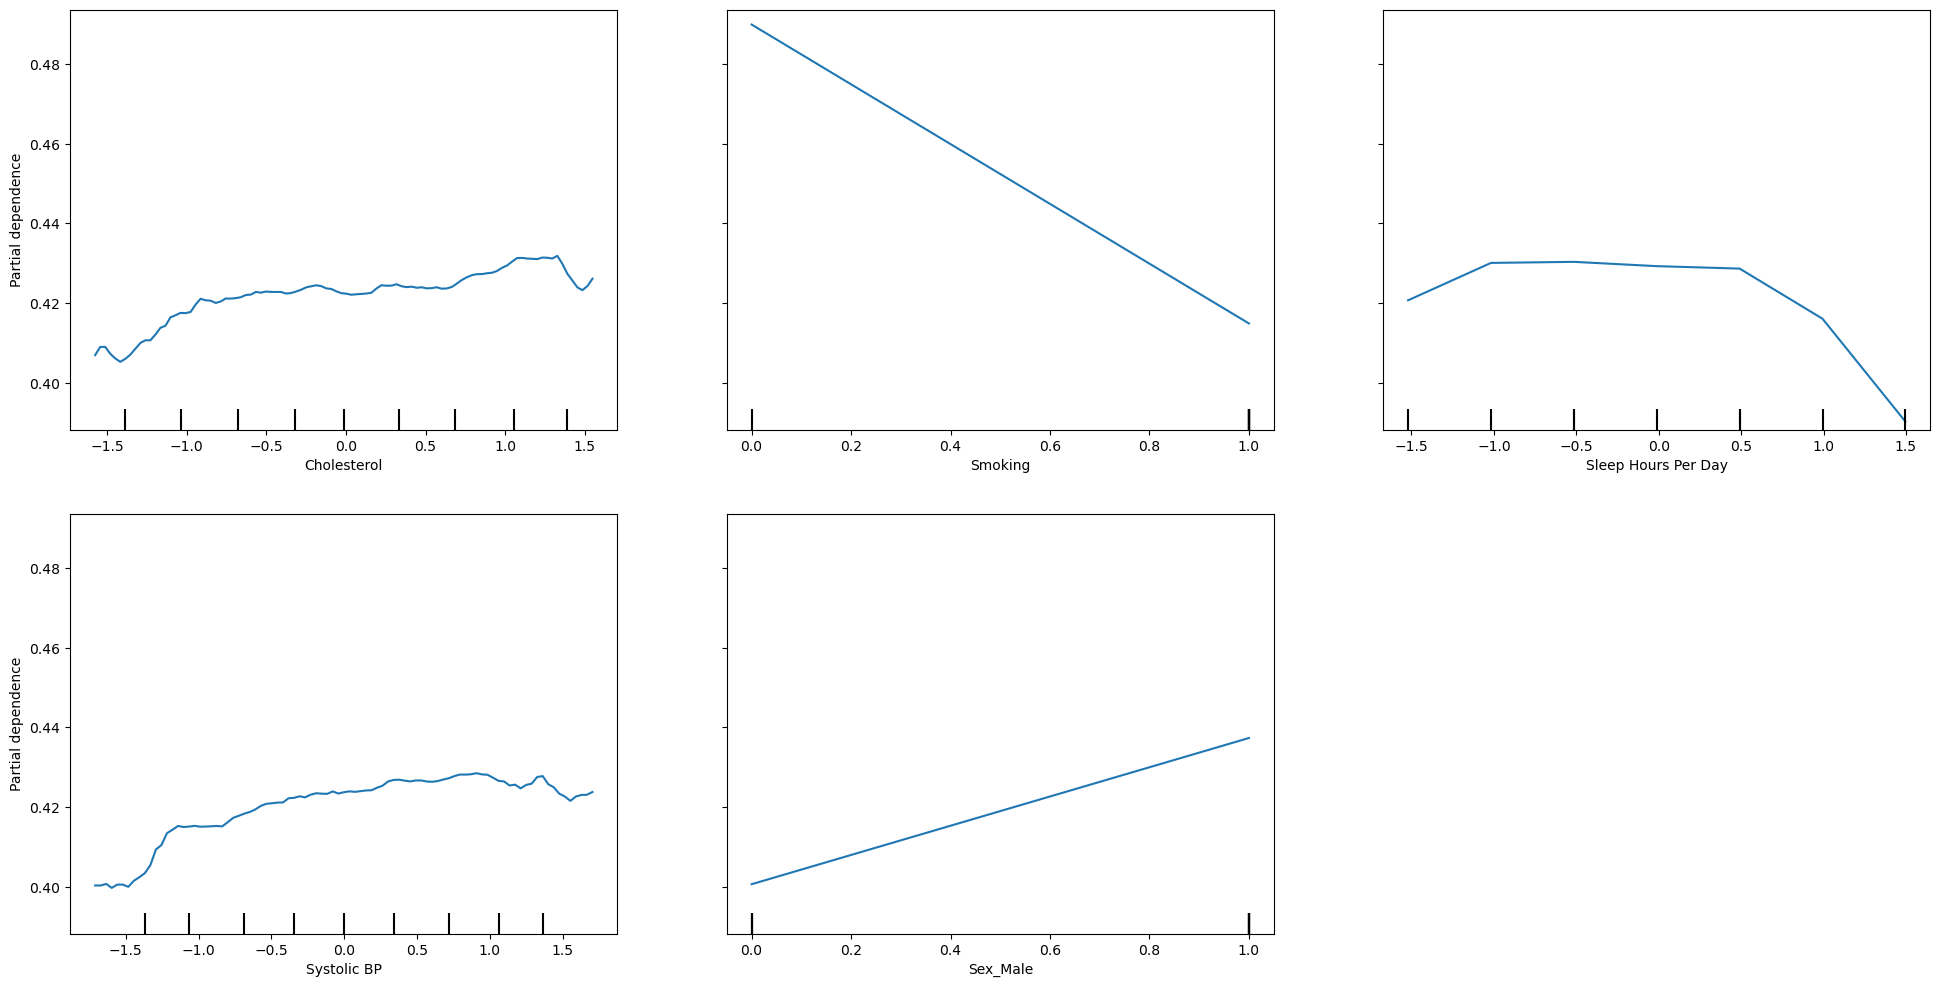

In [21]:
from sklearn.inspection import PartialDependenceDisplay

best_model = grid_search.best_estimator_

# Fit the best model on the entire dataset
best_model.fit(X, y)
features = [1, 5, 17, 19, 28]

# Plot the partial dependence
fig, ax = plt.subplots(figsize=(24, 12))
PartialDependenceDisplay.from_estimator(best_model, X, features, ax=ax)
plt.show()